In [2]:
import pickle
import os

data_dir = r"D:\Videos Zebrafish\ConfocalLike3 (Febrero 2024)"#r"N:\Data Labo"#
data_name = 'organized_data_behavior_2024_new_tracking.pkl' #"processed_data_oled_aud_9_ROIS.pkl" #

os.chdir(data_dir)

# Reading the list from the file using Pickle
with open(data_name, 'rb') as file:
    data = pickle.load(file)

In [83]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import random
import matplotlib.pyplot as plt

sigma = 2

def find_freezing_events(max_velocity, min_time, sigma):
    for stim_code in data.keys():
        if stim_code not in ["colors", "stim_labels", "stim_time", "stim_window"]:  # Exclude non-trial keys
            N = len(data[stim_code]["head_velocity"])
            data[stim_code]["freezing_events"] = []
            
            for i in range(N):
                head_velocity_raw = data[stim_code]["head_velocity"][i]
                # Apply Gaussian smoothing
                head_velocity = gaussian_filter1d(head_velocity_raw, sigma=sigma)
                
                freezing_events = []
                start = None
                
                for t in range(len(head_velocity)):
                    if head_velocity[t] < max_velocity:
                        if start is None:
                            start = t
                    else:
                        if start is not None and t - start >= min_time:
                            freezing_events.append((start, t))
                        start = None
                
                # Check if the last segment qualifies as a freezing event
                if start is not None and len(head_velocity) - start >= min_time:
                    freezing_events.append((start, len(head_velocity)))
                
                data[stim_code]["freezing_events"].append(freezing_events)
                
find_freezing_events(max_velocity=0.3, min_time=1500, sigma=sigma)

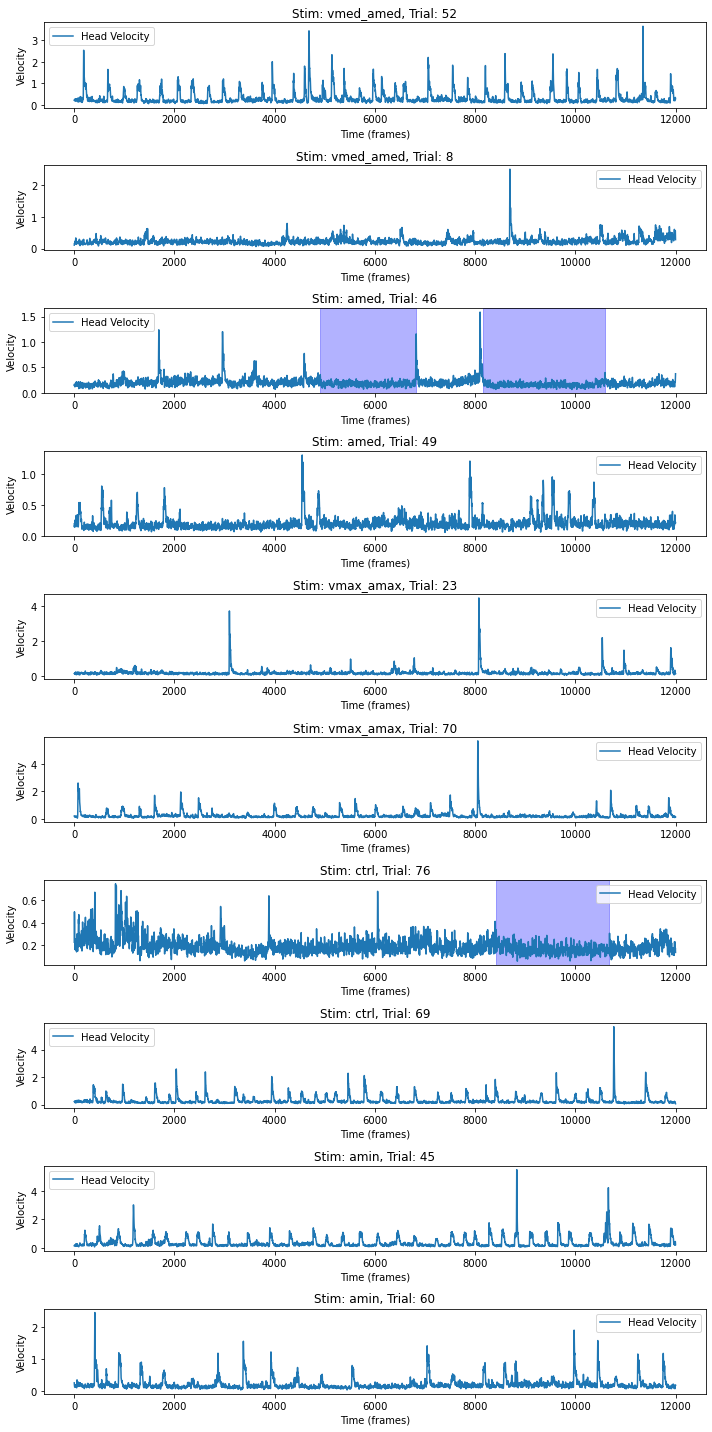

In [84]:
def plot_random_trials_with_freezing(sigma):
    selected_stims = random.sample([key for key in data.keys() if key not in ["colors", "stim_labels", "stim_time", "stim_window"]], 5)
    
    fig, axs = plt.subplots(len(selected_stims) * 2, 1, figsize=(10, 20))
    
    for i, stim_code in enumerate(selected_stims):
        selected_trials = random.sample(range(len(data[stim_code]["head_velocity"])), 2)
        
        for j, trial in enumerate(selected_trials):
            ax = axs[i * 2 + j]
            head_velocity = data[stim_code]["head_velocity"][trial]
            head_velocity = gaussian_filter1d(head_velocity, sigma=sigma)
            ax.plot(head_velocity, label='Head Velocity')
            ax.set_title(f"Stim: {stim_code}, Trial: {trial}")
            
            # Shading freezing events
            for start, end in data[stim_code]["freezing_events"][trial]:
                ax.axvspan(start, end, color='blue', alpha=0.3)
            
            ax.set_xlabel("Time (frames)")
            ax.set_ylabel("Velocity")
            ax.legend()
    
    plt.tight_layout()
    plt.show()
    
# Then, plot the selected trials with freezing events
plot_random_trials_with_freezing(sigma)

In [40]:
import pickle

os.chdir(r"D:\Videos Zebrafish\ConfocalLike3 (Febrero 2024)")

# Writing the list to a file using Pickle
with open('organized_data_behavior_2024_with_freezing.pkl', 'wb') as file:
    pickle.dump(data, file)

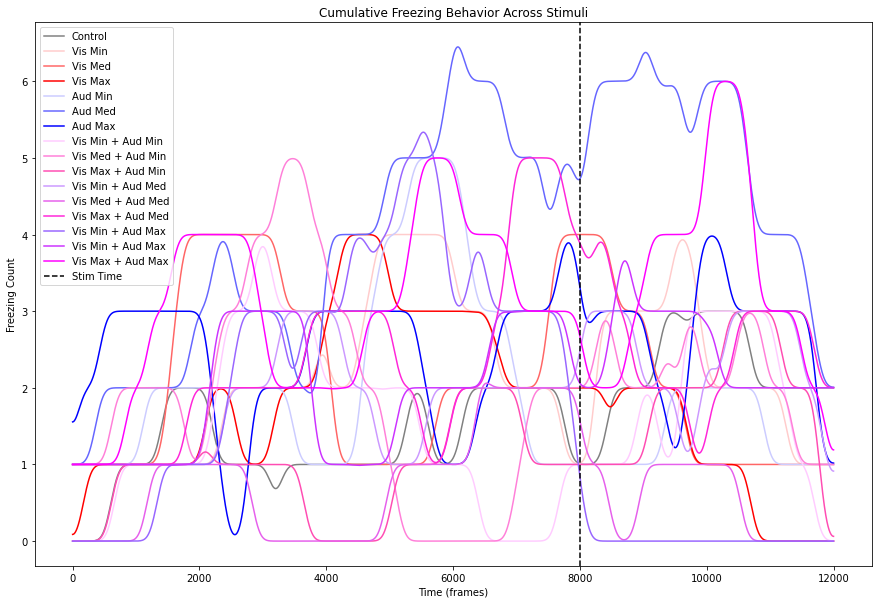

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a plot
plt.figure(figsize=(15, 10))

for stim_code in data["colors"].keys():
    N = len(data[stim_code]["head_velocity"])
    cumulative_freezing = np.zeros(12000)

    for i in range(N):
        for start, end in data[stim_code]["freezing_events"][i]:
            cumulative_freezing[start:end] += 1
    cumulative_freezing = gaussian_filter1d(cumulative_freezing, sigma=100)
    plt.plot(cumulative_freezing, label=data["stim_labels"][stim_code], color=data["colors"][stim_code])

# Mark the stimulation time
stim_time = data["stim_time"]
plt.axvline(x=stim_time, color='k', linestyle='--', label='Stim Time')

# Enhance the plot
plt.xlabel('Time (frames)')
plt.ylabel('Freezing Count')
plt.title('Cumulative Freezing Behavior Across Stimuli')
plt.legend()
plt.show()

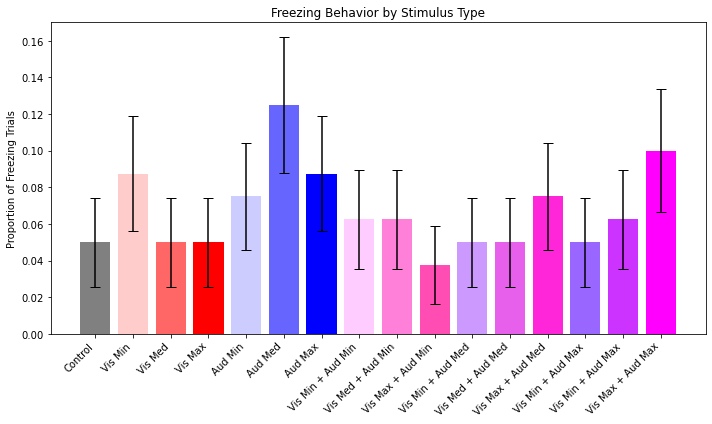

In [86]:
import numpy as np
import matplotlib.pyplot as plt

stim_start, stim_end = 6000,10000
proportions = []
errors = []
labels = []

for stim_code in data["colors"].keys():
    N = len(data[stim_code]["head_velocity"])
    freezing_trials = 0

    for i in range(N):
        for start, end in data[stim_code]["freezing_events"][i]:
            if start < stim_end and end > stim_start:  # Overlap with stim window
                freezing_trials += 1
                break

    proportion = freezing_trials / N
    proportions.append(proportion)
    error = np.sqrt(proportion * (1 - proportion) / N)  # Binomial standard error
    errors.append(error)
    labels.append(data["stim_labels"][stim_code])

# Bar plot with error bars
plt.figure(figsize=(10, 6))
x = range(len(labels))
plt.bar(x, proportions, yerr=errors, capsize=5, color=list(data["colors"].values()))
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel('Proportion of Freezing Trials')
plt.title('Freezing Behavior by Stimulus Type')
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()


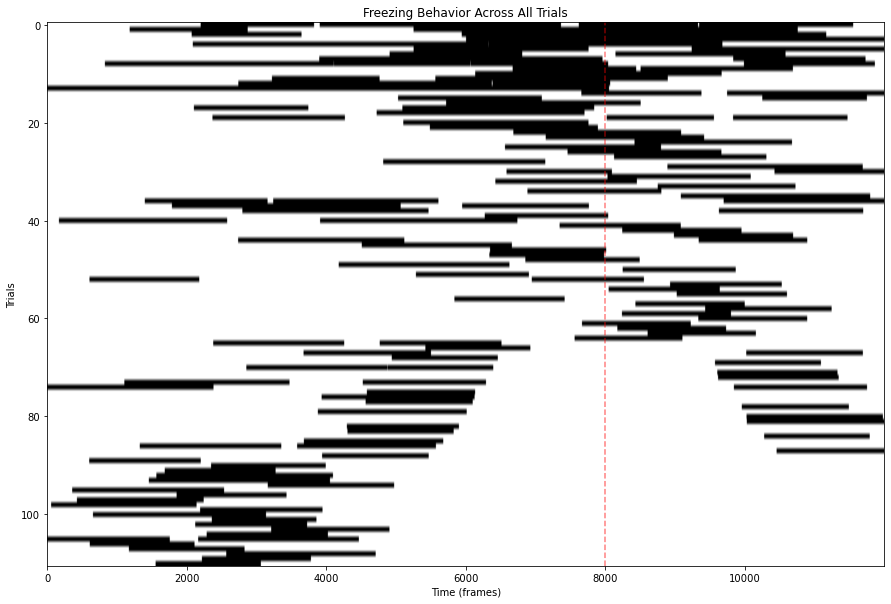

In [87]:
import numpy as np
import matplotlib.pyplot as plt

stim_start, stim_end = 5000,11000
all_freezing = []

# Pool freezing intervals and flag those with freezing in the stim window
for stim_code in data["colors"].keys():
    if stim_code not in ["colors", "stim_labels", "stim_time", "stim_window"]:
        for i in range(len(data[stim_code]["head_velocity"])):
            freezing_intervals = data[stim_code]["freezing_events"][i]
            if freezing_intervals:  # Check if the list is not empty
                # Calculate total freezing duration over the whole trial
                total_freezing_duration = sum(end - start for start, end in freezing_intervals)

                # Trial duration is known to be 12000 frames
                trial_duration = 12000
                proportion_of_freezing_whole_trial = total_freezing_duration / trial_duration
                
                if proportion_of_freezing_whole_trial <= 0.8:  # If freezing less than 80% of the whole trial
                    # Inside the loop collecting freezing intervals
                    freezing_durations_within_stim = sum(
                        max(0, min(end, stim_end) - max(start, stim_start))
                        for start, end in freezing_intervals
                    )
                    total_stim_duration = stim_end - stim_start
                    proportion_of_freezing = freezing_durations_within_stim / total_stim_duration if freezing_intervals else 0
                    all_freezing.append((freezing_intervals, proportion_of_freezing))

#                 freezing_in_stim_window = any(start < stim_end and end > stim_start for start, end in freezing_intervals)
#                 all_freezing.append((freezing_intervals, freezing_in_stim_window))

#                 first_freezing_moment = min(start for start, end in freezing_intervals)
#                 all_freezing.append((freezing_intervals, first_freezing_moment))

# Sort trials based on whether they had freezing in the stim window
#all_freezing_sorted = sorted(all_freezing, key=lambda x: not x[0])

# Sorting by proportion of freezing, ensure it's in descending order for higher proportions first
all_freezing_sorted = sorted(all_freezing, key=lambda x: x[1], reverse=True)

# Create the matrix
freezing_matrix = np.zeros((len(all_freezing_sorted), 12000))
for i, (freezing_intervals, _) in enumerate(all_freezing_sorted):
    for start, end in freezing_intervals:
        freezing_matrix[i, start:end] = 1

# Show the matrix using imshow
plt.figure(figsize=(15, 10))
plt.imshow(freezing_matrix, aspect='auto', cmap='binary')
#plt.colorbar(label='Freezing Behavior (1=Freezing, 0=Not Freezing)')
plt.xlabel('Time (frames)')
plt.ylabel('Trials')
plt.title('Freezing Behavior Across All Trials')
plt.axvline(x=stim_time, color='r', linestyle='--', label='Stim Time', alpha=0.5)
plt.show()


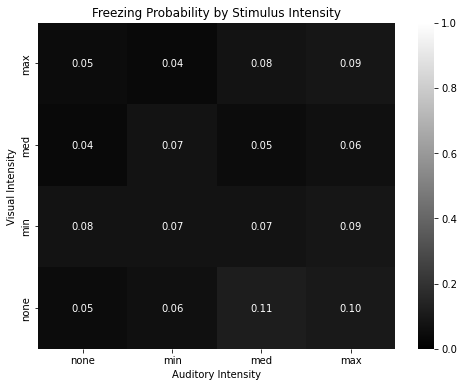

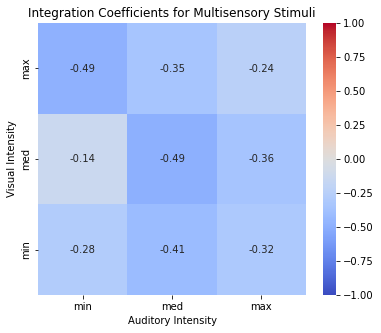

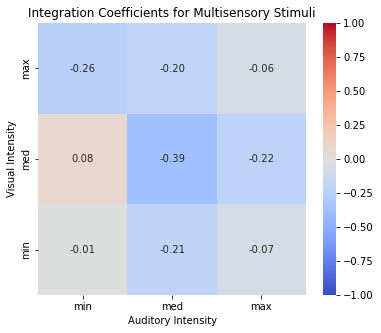

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the stimulus intensity labels and the structure to hold probabilities
intensity_labels = ['none', 'min', 'med', 'max']
probability_matrix = np.zeros((4, 4))  # Initialize a 4x4 matrix

# Calculate freezing probabilities for each stim type and fill the matrix
for visual_intensity in intensity_labels:
    for auditory_intensity in intensity_labels:
        if visual_intensity == 'none' and auditory_intensity == 'none':
            stim_code = 'ctrl'
        elif visual_intensity == 'none':
            stim_code = f'a{auditory_intensity}'
        elif auditory_intensity == 'none':
            stim_code = f'v{visual_intensity}'
        else:
            stim_code = f'v{visual_intensity}_a{auditory_intensity}'
        
        
        N = len(data[stim_code]["head_velocity"])
        freezing_trials = 0
        total_trials = 0
        

        for i in range(N):
            
            freezing_intervals = data[stim_code]["freezing_events"][i]
            
            # Calculate total freezing duration over the whole trial
            total_freezing_duration = sum(end - start for start, end in freezing_intervals)

            # Trial duration is known to be 12000 frames
            trial_duration = 12000
            proportion_of_freezing_whole_trial = total_freezing_duration / trial_duration

            if proportion_of_freezing_whole_trial <= 0.8:  # If freezing less than 80% of the whole trial
                total_trials+=1
                for start, end in data[stim_code]["freezing_events"][i]:
                    if start < stim_end and end > stim_start:  # Overlap with stim window
                        freezing_trials += 1
                        break

        probability = freezing_trials / total_trials
        y_index = intensity_labels.index(visual_intensity)
        x_index = intensity_labels.index(auditory_intensity)
        probability_matrix[y_index, x_index] = probability

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(probability_matrix, annot=True, fmt=".2f", cmap='gray', vmin=0, vmax=1, xticklabels=intensity_labels, yticklabels=intensity_labels)
plt.title('Freezing Probability by Stimulus Intensity')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()


# Initialize a 3x3 matrix for integration coefficients
integration_coefficients_matrix = np.zeros((3, 3))

# Iterate over multisensory stimuli (excluding 'none')
for v_index, visual_intensity in enumerate(intensity_labels[1:], start=1):
    for a_index, auditory_intensity in enumerate(intensity_labels[1:], start=1):
        # Observed probability for multisensory stimulus
        observed = probability_matrix[v_index, a_index]
        
        # Unisensory probabilities
        v = probability_matrix[v_index, 0]  # Visual only
        a = probability_matrix[0, a_index]  # Auditory only
        
        # Expected multisensory probability
        expected = v + a - v * a
        
        # Integration coefficient calculation
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        
        # Fill the 3x3 matrix
        integration_coefficients_matrix[v_index-1, a_index-1] = integration_coefficient

# Plotting the heatmap of integration coefficients
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, xticklabels=intensity_labels[1:], yticklabels=intensity_labels[1:])
plt.title('Integration Coefficients for Multisensory Stimuli')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()


# Initialize a 3x3 matrix for integration coefficients
integration_coefficients_matrix = np.zeros((3, 3))

# Iterate over multisensory stimuli (excluding 'none')
for v_index, visual_intensity in enumerate(intensity_labels[1:], start=1):
    for a_index, auditory_intensity in enumerate(intensity_labels[1:], start=1):
        # Observed probability for multisensory stimulus
        observed = probability_matrix[v_index, a_index]
        
        # Unisensory probabilities
        v = probability_matrix[v_index, 0]  # Visual only
        a = probability_matrix[0, a_index]  # Auditory only
        
        # Expected multisensory probability
        expected = max(v, a)
        
        # Integration coefficient calculation
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        
        # Fill the 3x3 matrix
        integration_coefficients_matrix[v_index-1, a_index-1] = integration_coefficient

# Plotting the heatmap of integration coefficients
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, xticklabels=intensity_labels[1:], yticklabels=intensity_labels[1:])
plt.title('Integration Coefficients for Multisensory Stimuli')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()


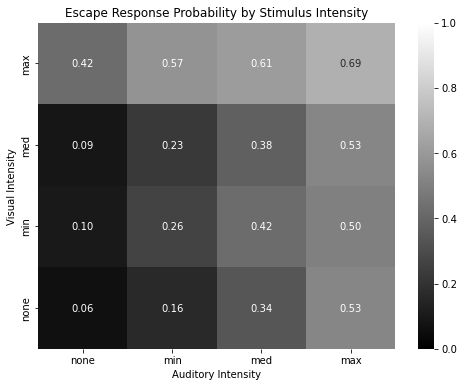

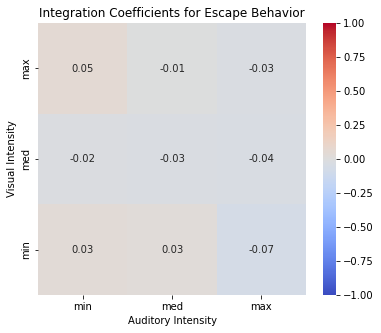

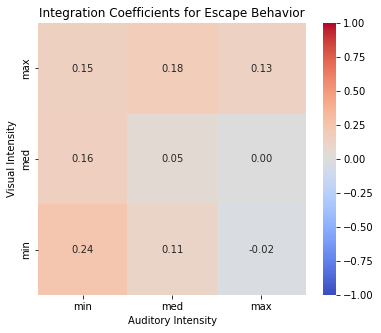

In [89]:
# Initialize the 4x4 matrix for escape probabilities
escape_probability_matrix = np.zeros((4, 4))
stim_start, stim_end = data["stim_window"]

# Calculate escape probabilities for each stim type
for visual_idx, visual_intensity in enumerate(['none', 'min', 'med', 'max']):
    for auditory_idx, auditory_intensity in enumerate(['none', 'min', 'med', 'max']):
        if visual_intensity == 'none' and auditory_intensity == 'none':
            stim_code = 'ctrl'
        elif visual_intensity == 'none':
            stim_code = f'a{auditory_intensity}'
        elif auditory_intensity == 'none':
            stim_code = f'v{visual_intensity}'
        else:
            stim_code = f'v{visual_intensity}_a{auditory_intensity}'
        
        # Determine if there is an escape event during the stimulation window
        trials_with_escape = sum(
            any(stim_start < event_time < stim_end for event_time in trial_events)
            for trial_events in data[stim_code]["valid_event_times"]
        )
        total_trials = len(data[stim_code]["valid_event_times"])
        
        # Calculate the proportion of trials with escape
        escape_probability = trials_with_escape / total_trials if total_trials > 0 else 0
        escape_probability_matrix[visual_idx, auditory_idx] = escape_probability

# Plotting the escape probability matrix
plt.figure(figsize=(8, 6))
sns.heatmap(escape_probability_matrix, annot=True, fmt=".2f", cmap='gray',
            xticklabels=['none', 'min', 'med', 'max'],
            yticklabels=['none', 'min', 'med', 'max'], vmin=0, vmax=1)
plt.title('Escape Response Probability by Stimulus Intensity')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()        


# Initialize the 3x3 matrix for integration coefficients
integration_coefficients_escape = np.zeros((3, 3))

# Calculate integration coefficients
for v_index in range(1, 4):
    for a_index in range(1, 4):
        observed = escape_probability_matrix[v_index, a_index]
        v = escape_probability_matrix[v_index, 0]
        a = escape_probability_matrix[0, a_index]
        expected = v + a - v * a
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        integration_coefficients_escape[v_index-1, a_index-1] = integration_coefficient

# Plotting the integration coefficients matrix for escape behavior
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_escape, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
plt.title('Integration Coefficients for Escape Behavior')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()


# Initialize the 3x3 matrix for integration coefficients
integration_coefficients_escape = np.zeros((3, 3))

# Calculate integration coefficients
for v_index in range(1, 4):
    for a_index in range(1, 4):
        observed = escape_probability_matrix[v_index, a_index]
        v = escape_probability_matrix[v_index, 0]
        a = escape_probability_matrix[0, a_index]
        expected = max(v,a)
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        integration_coefficients_escape[v_index-1, a_index-1] = integration_coefficient

# Plotting the integration coefficients matrix for escape behavior
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_escape, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
plt.title('Integration Coefficients for Escape Behavior')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()

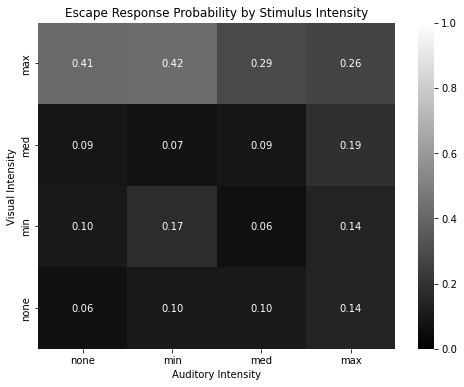

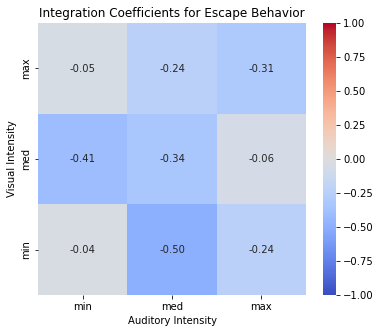

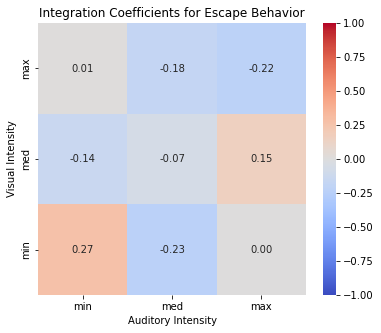

In [90]:
target = 0

# Initialize the 4x4 matrix for escape probabilities
escape_probability_matrix = np.zeros((4, 4))
stim_start, stim_end = data["stim_window"]

# Calculate escape probabilities for each stim type
for visual_idx, visual_intensity in enumerate(['none', 'min', 'med', 'max']):
    for auditory_idx, auditory_intensity in enumerate(['none', 'min', 'med', 'max']):
        if visual_intensity == 'none' and auditory_intensity == 'none':
            stim_code = 'ctrl'
        elif visual_intensity == 'none':
            stim_code = f'a{auditory_intensity}'
        elif auditory_intensity == 'none':
            stim_code = f'v{visual_intensity}'
        else:
            stim_code = f'v{visual_intensity}_a{auditory_intensity}'
        
        trials_with_escape = 0
        
        for i, trial_events in enumerate(data[stim_code]["valid_event_times"]):
            behavior_types = data[stim_code]["behavior_type"][i]
            
            if len(behavior_types) == 0:
                continue
            
            for j, event_time in enumerate(trial_events):
                if (stim_start < event_time < stim_end) and (behavior_types[j] == target):
                    trials_with_escape += 1
        
        total_trials = len(data[stim_code]["valid_event_times"])
        
        # Calculate the proportion of trials with escape
        escape_probability = trials_with_escape / total_trials if total_trials > 0 else 0
        escape_probability_matrix[visual_idx, auditory_idx] = escape_probability

# Plotting the escape probability matrix
plt.figure(figsize=(8, 6))
sns.heatmap(escape_probability_matrix, annot=True, fmt=".2f", cmap='gray',
            xticklabels=['none', 'min', 'med', 'max'],
            yticklabels=['none', 'min', 'med', 'max'], vmin=0, vmax=1)
plt.title('Escape Response Probability by Stimulus Intensity')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()        


# Initialize the 3x3 matrix for integration coefficients
integration_coefficients_escape = np.zeros((3, 3))

# Calculate integration coefficients
for v_index in range(1, 4):
    for a_index in range(1, 4):
        observed = escape_probability_matrix[v_index, a_index]
        v = escape_probability_matrix[v_index, 0]
        a = escape_probability_matrix[0, a_index]
        expected = v + a - v * a
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        integration_coefficients_escape[v_index-1, a_index-1] = integration_coefficient

# Plotting the integration coefficients matrix for escape behavior
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_escape, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
plt.title('Integration Coefficients for Escape Behavior')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()


# Initialize the 3x3 matrix for integration coefficients
integration_coefficients_escape = np.zeros((3, 3))

# Calculate integration coefficients
for v_index in range(1, 4):
    for a_index in range(1, 4):
        observed = escape_probability_matrix[v_index, a_index]
        v = escape_probability_matrix[v_index, 0]
        a = escape_probability_matrix[0, a_index]
        expected = max(v,a)
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        integration_coefficients_escape[v_index-1, a_index-1] = integration_coefficient

# Plotting the integration coefficients matrix for escape behavior
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_escape, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
plt.title('Integration Coefficients for Escape Behavior')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()

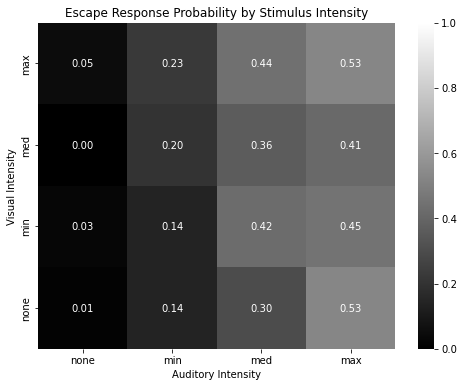

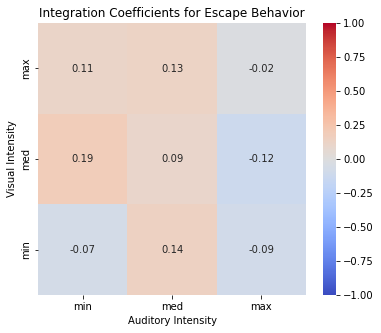

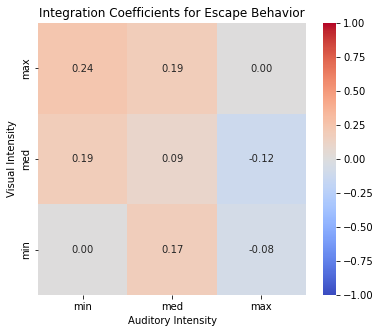

In [91]:
target = 1

# Initialize the 4x4 matrix for escape probabilities
escape_probability_matrix = np.zeros((4, 4))
stim_start, stim_end = data["stim_window"]

# Calculate escape probabilities for each stim type
for visual_idx, visual_intensity in enumerate(['none', 'min', 'med', 'max']):
    for auditory_idx, auditory_intensity in enumerate(['none', 'min', 'med', 'max']):
        if visual_intensity == 'none' and auditory_intensity == 'none':
            stim_code = 'ctrl'
        elif visual_intensity == 'none':
            stim_code = f'a{auditory_intensity}'
        elif auditory_intensity == 'none':
            stim_code = f'v{visual_intensity}'
        else:
            stim_code = f'v{visual_intensity}_a{auditory_intensity}'
        
        trials_with_escape = 0
        
        for i, trial_events in enumerate(data[stim_code]["valid_event_times"]):
            behavior_types = data[stim_code]["behavior_type"][i]
            
            if len(behavior_types) == 0:
                continue
            
            for j, event_time in enumerate(trial_events):
                if (stim_start < event_time < stim_end) and (behavior_types[j] == target):
                    trials_with_escape += 1
        
        total_trials = len(data[stim_code]["valid_event_times"])
        
        # Calculate the proportion of trials with escape
        escape_probability = trials_with_escape / total_trials if total_trials > 0 else 0
        escape_probability_matrix[visual_idx, auditory_idx] = escape_probability

# Plotting the escape probability matrix
plt.figure(figsize=(8, 6))
sns.heatmap(escape_probability_matrix, annot=True, fmt=".2f", cmap='gray',
            xticklabels=['none', 'min', 'med', 'max'],
            yticklabels=['none', 'min', 'med', 'max'], vmin=0, vmax=1)
plt.title('Escape Response Probability by Stimulus Intensity')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()        


# Initialize the 3x3 matrix for integration coefficients
integration_coefficients_escape = np.zeros((3, 3))

# Calculate integration coefficients
for v_index in range(1, 4):
    for a_index in range(1, 4):
        observed = escape_probability_matrix[v_index, a_index]
        v = escape_probability_matrix[v_index, 0]
        a = escape_probability_matrix[0, a_index]
        expected = v + a - v * a
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        integration_coefficients_escape[v_index-1, a_index-1] = integration_coefficient

# Plotting the integration coefficients matrix for escape behavior
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_escape, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
plt.title('Integration Coefficients for Escape Behavior')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()


# Initialize the 3x3 matrix for integration coefficients
integration_coefficients_escape = np.zeros((3, 3))

# Calculate integration coefficients
for v_index in range(1, 4):
    for a_index in range(1, 4):
        observed = escape_probability_matrix[v_index, a_index]
        v = escape_probability_matrix[v_index, 0]
        a = escape_probability_matrix[0, a_index]
        expected = max(v,a)
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        integration_coefficients_escape[v_index-1, a_index-1] = integration_coefficient

# Plotting the integration coefficients matrix for escape behavior
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_escape, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
plt.title('Integration Coefficients for Escape Behavior')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()

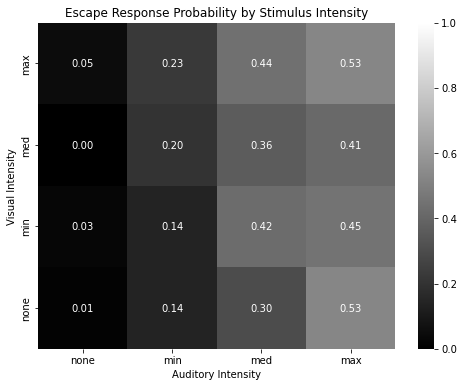

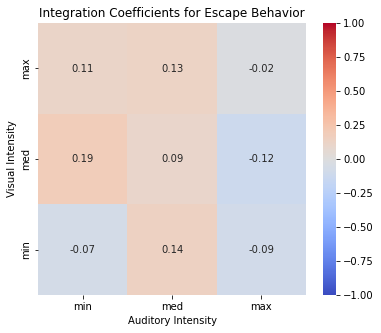

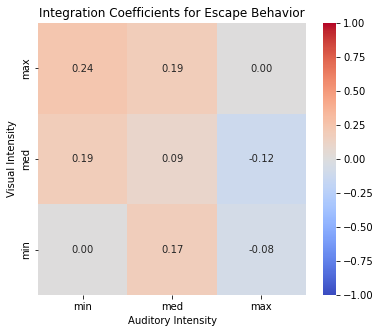

In [92]:
stim_start, stim_end = data["stim_window"]
intensity_labels = ['none', 'min', 'med', 'max']
probability_matrix = np.zeros((4, 4))

for v_idx, visual_intensity in enumerate(intensity_labels):
    for a_idx, auditory_intensity in enumerate(intensity_labels):
        if visual_intensity == 'none' and auditory_intensity == 'none':
            stim_code = 'ctrl'
        elif visual_intensity == 'none':
            stim_code = f'a{auditory_intensity}'
        elif auditory_intensity == 'none':
            stim_code = f'v{visual_intensity}'
        else:
            stim_code = f'v{visual_intensity}_a{auditory_intensity}'
        
        positive_trials = 0
        total_trials = len(data[stim_code]["head_velocity"])
        
        for i in range(total_trials):
            # Check for valid events in stim window
            has_valid_event = any(stim_start <= event_time < stim_end for event_time in data[stim_code]["valid_event_times"][i])
            # Check for freezing behavior in stim window
            has_freezing = any(start < stim_end and end > stim_start for start, end in data[stim_code]["freezing_events"][i])
            
            if has_valid_event or has_freezing:
                positive_trials += 1
                
        probability = positive_trials / total_trials if total_trials > 0 else 0
        probability_matrix[v_idx, a_idx] = probability

        
# Plotting the escape probability matrix
plt.figure(figsize=(8, 6))
sns.heatmap(escape_probability_matrix, annot=True, fmt=".2f", cmap='gray',
            xticklabels=['none', 'min', 'med', 'max'],
            yticklabels=['none', 'min', 'med', 'max'], vmin=0, vmax=1)
plt.title('Escape Response Probability by Stimulus Intensity')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()        


# Initialize the 3x3 matrix for integration coefficients
integration_coefficients_escape = np.zeros((3, 3))

# Calculate integration coefficients
for v_index in range(1, 4):
    for a_index in range(1, 4):
        observed = escape_probability_matrix[v_index, a_index]
        v = escape_probability_matrix[v_index, 0]
        a = escape_probability_matrix[0, a_index]
        expected = v + a - v * a
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        integration_coefficients_escape[v_index-1, a_index-1] = integration_coefficient

# Plotting the integration coefficients matrix for escape behavior
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_escape, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
plt.title('Integration Coefficients for Escape Behavior')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()


# Initialize the 3x3 matrix for integration coefficients
integration_coefficients_escape = np.zeros((3, 3))

# Calculate integration coefficients
for v_index in range(1, 4):
    for a_index in range(1, 4):
        observed = escape_probability_matrix[v_index, a_index]
        v = escape_probability_matrix[v_index, 0]
        a = escape_probability_matrix[0, a_index]
        expected = max(v,a)
        integration_coefficient = (observed - expected) / (observed + expected) if (observed + expected) != 0 else 0
        integration_coefficients_escape[v_index-1, a_index-1] = integration_coefficient

# Plotting the integration coefficients matrix for escape behavior
plt.figure(figsize=(6, 5))
sns.heatmap(integration_coefficients_escape, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['min', 'med', 'max'], yticklabels=['min', 'med', 'max'], vmin=-1, vmax=1)
plt.title('Integration Coefficients for Escape Behavior')
plt.xlabel('Auditory Intensity')
plt.ylabel('Visual Intensity')
plt.gca().invert_yaxis()  # Invert y-axis
plt.show()